In [2]:
from data_handle.data import Data
from models.FNO import FNO
from training.trainer import Trainer
import torch

torch.set_float32_matmul_precision('high')
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.benchmark = True

In [3]:
model = FNO(in_channels=10, out_channels=2, width=32, modes1=16, modes2=16, n_layers=3, padding=9)

In [4]:
dataset = Data()

Loaded 186 cases, 204690 samples


In [5]:
trainer = Trainer(model, dataset, batch_size=64)

cuda


In [ ]:
trainer.train_autoregressive(load_weights='/home/babay/programs/physics188/capstone/project/SHMS/src/training/epochs/rollout/model_weights_0')

start training
Total epochs: 50, Batches per epoch: 64


2559it [1:03:45,  1.50s/it]


Epoch [1/50] completed - Avg Loss: 0.005463, LR: 0.000100, Time: 3826.56s


248it [17:55,  4.34s/it]


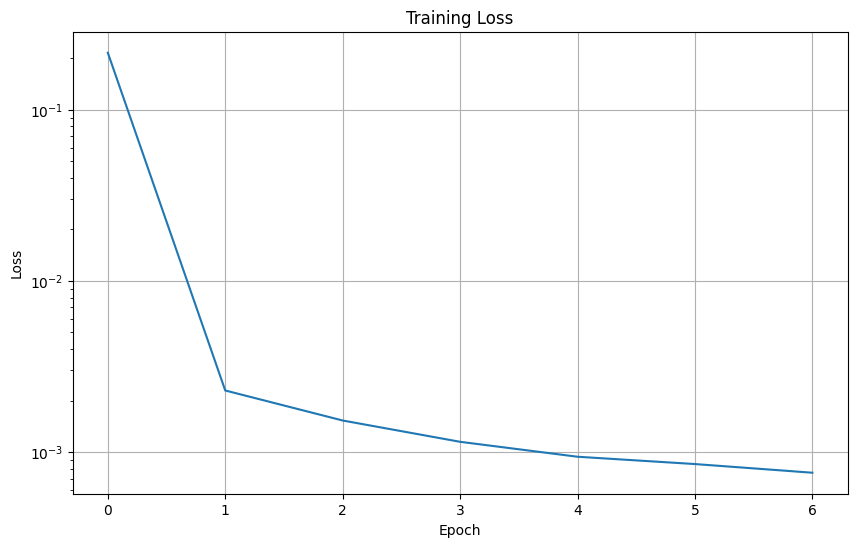

In [ ]:
trainer.show_loss()

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def visualize_prediction(
    model: torch.nn.Module,
    dataset,
    checkpoint_path: str = None,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',
    sample_idx: int = None,
    rollout_step: int = 0,  # which timestep to visualize
    figsize: tuple = (16, 8)
):
    """
    Visualize model prediction vs ground truth.
    
    Args:
        model: FNO model
        dataset: test dataset
        checkpoint_path: path to model weights (optional if already loaded)
        device: device to run inference on
        sample_idx: specific sample index (random if None)
        rollout_step: which future timestep to visualize (0 to rollout_steps-1)
        figsize: figure size
    """
    model = model.to(device)
    
    # Load weights if provided
    if checkpoint_path:
        model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    
    model.eval()
    
    # Get random sample if not specified
    if sample_idx is None:
        sample_idx = np.random.randint(0, len(dataset))
    
    x, y = dataset[sample_idx]
    x = x.unsqueeze(0).to(device)  # [1, H, W, C]
    y = y.to(device)                # [T, H, W, 2] or [H, W, 2]
    
    # Get target for the specified rollout step
    if y.dim() == 4:
        target = y[rollout_step]  # [H, W, 2]
    else:
        target = y  # [H, W, 2]
    
    # Run inference
    with torch.no_grad():
        pred = model(x).squeeze(0)  # [H, W, 2]
    
    # Compute error
    error = (pred - target).abs()
    
    # Move to CPU for plotting
    x_np = x.squeeze(0).cpu().numpy()
    target_np = target.cpu().numpy()
    pred_np = pred.cpu().numpy()
    error_np = error.cpu().numpy()
    
    # Create figure: 2 rows (u_x, u_y) x 4 cols (input, target, pred, error)
    fig, axes = plt.subplots(2, 4, figsize=figsize)
    
    channel_names = ['$u_x$', '$u_y$']
    col_titles = ['Input', 'Ground Truth', 'Prediction', 'Absolute Error']
    
    for row, (name, ch) in enumerate(zip(channel_names, [0, 1])):
        # Input (velocity component from input)
        im0 = axes[row, 0].imshow(x_np[:, :, ch], cmap='RdBu_r')
        plt.colorbar(im0, ax=axes[row, 0], fraction=0.046)
        
        # Ground truth
        im1 = axes[row, 1].imshow(target_np[:, :, ch], cmap='RdBu_r')
        plt.colorbar(im1, ax=axes[row, 1], fraction=0.046)
        
        # Prediction
        im2 = axes[row, 2].imshow(pred_np[:, :, ch], cmap='RdBu_r')
        plt.colorbar(im2, ax=axes[row, 2], fraction=0.046)
        
        # Error
        im3 = axes[row, 3].imshow(error_np[:, :, ch], cmap='hot')
        plt.colorbar(im3, ax=axes[row, 3], fraction=0.046)
        
        # Row labels
        axes[row, 0].set_ylabel(name, fontsize=12)
    
    # Column titles
    for col, title in enumerate(col_titles):
        axes[0, col].set_title(title, fontsize=12)
    
    # Remove ticks
    for ax in axes.flat:
        ax.set_xticks([])
        ax.set_yticks([])
    
    plt.suptitle(f'Sample {sample_idx} | Rollout Step {rollout_step}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    # Print error statistics
    mae_ux = error_np[:, :, 0].mean()
    mae_uy = error_np[:, :, 1].mean()
    mae_total = error_np.mean()
    
    print(f"Mean Absolute Error:")
    print(f"  u_x: {mae_ux:.6f}")
    print(f"  u_y: {mae_uy:.6f}")
    print(f"  Total: {mae_total:.6f}")
    
    return pred_np, target_np, error_np


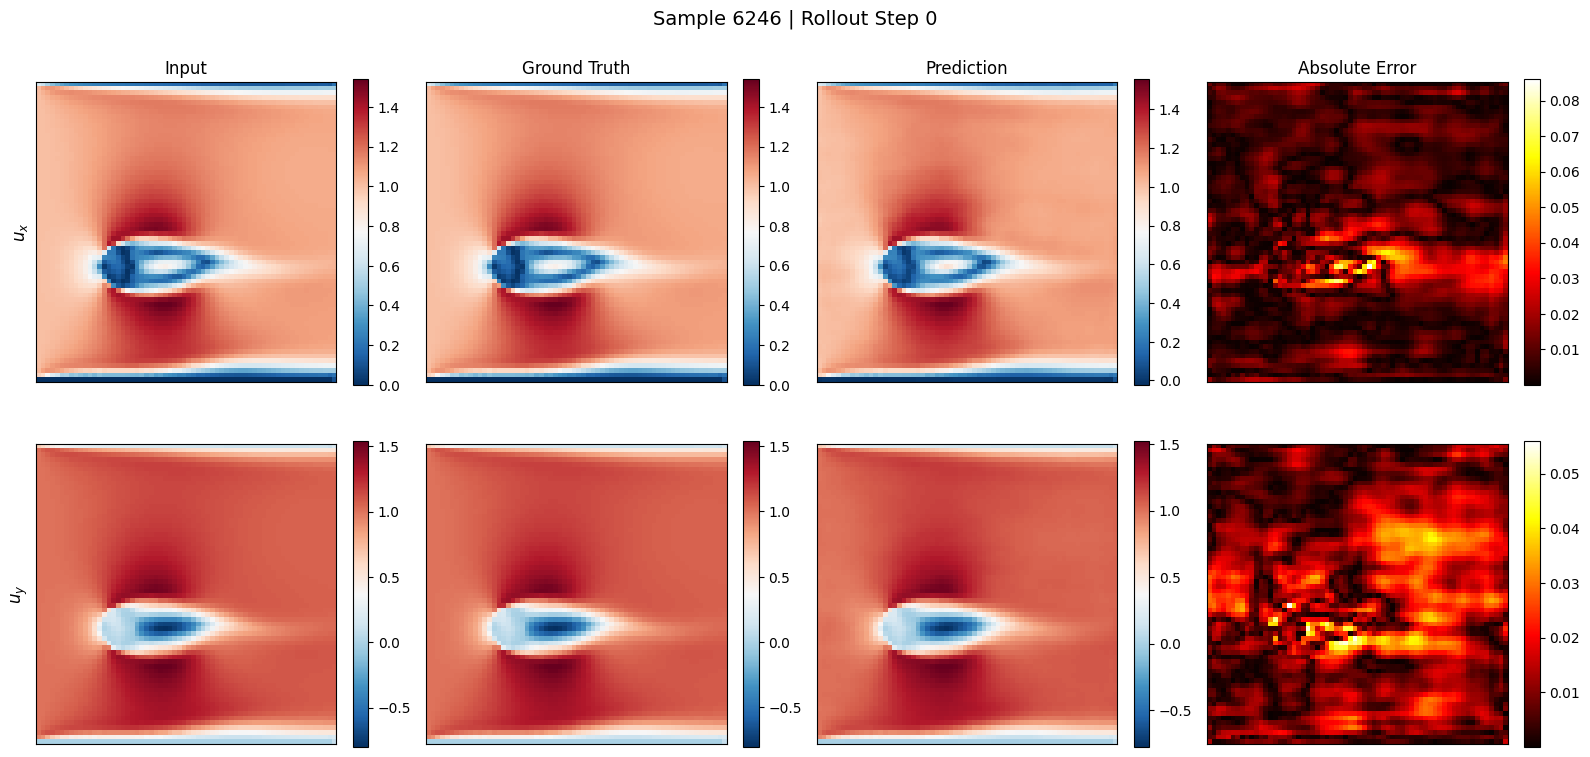

Mean Absolute Error:
  u_x: 0.010421
  u_y: 0.012891
  Total: 0.011656


In [ ]:
pred, target, error = visualize_prediction(model, trainer.test_set, '/home/babay/programs/physics188/capstone/project/SHMS/src/training/epochs/model_weights_6')